In [0]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "*******" # username from the json file
os.environ['KAGGLE_KEY'] = "*********" # key from the json file

!kaggle datasets download -d ming666/flicker8k-dataset

100% 2.07G/2.08G [00:51<00:00, 40.4MB/s]
100% 2.08G/2.08G [00:52<00:00, 42.9MB/s]


In [0]:
!kaggle datasets download -d watts2/glove6b50dtxt

 61% 41.0M/67.7M [00:01<00:01, 19.1MB/s]
100% 67.7M/67.7M [00:01<00:00, 48.3MB/s]


In [0]:
!unzip glove6b50dtxt.zip

Archive:  glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [0]:
!unzip flicker8k-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847514745_9a35493023.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848266893_9693c66275.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848571082_26454cb981.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2849194983_2968c72832.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2850719435_221f15e951.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851198725_37b6027625.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: flickr8k_dataset/Flicker

In [0]:
!ls

flicker8k-dataset.zip  Flickr8k_Dataset  Flickr8k_text
flickr8k_dataset       flickr8k_text	 sample_data


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [0]:
# After text cleaning we extract our cleaned captions from dexcriptions.txt

descriptions = None
with open("/content/descriptions_1.txt" , "r") as f:
  descriptions = f.read()

# Convert our processed text captions into a python dictionary
acceptable_json = descriptions.replace("'" , "\"")
descriptions = json.loads(acceptable_json)

print(type(descriptions))

<class 'dict'>


In [0]:
# Building vocab

vocab = set()
k=1

for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]]
  # if(k==1):
  #   print(descriptions[key])
  #   k=2

print("Size of vocab is %d"%len(vocab))

Size of vocab is 7742


In [0]:
# Total words availaible

total_words = []

for key in descriptions.keys():
  [total_words.append(word) for des in descriptions[key] for word in des.split()]

print(len(total_words))

346753


In [0]:
# Apply more filter to our word stock and reduce our vocab size by applying certain threshold

import collections

counter = collections.Counter(total_words)
print(type(counter))

# Convert to dictionary
freq_words = dict(counter)

print(len(freq_words.keys()))

<class 'collections.Counter'>
7742


In [0]:
# Now sort our dictionary with the freq count to simply removal of words 
# remove words freq[words] < threshold

sorted_freq_words = sorted(freq_words.items() , reverse=True , key = lambda x:x[1])

# now filter
threshold = 8
sorted_freq_words = [x for x in sorted_freq_words if x[1] > threshold]

total_words = [x[0] for x in sorted_freq_words]

print(len(total_words))


2070


In [0]:
# Prepare train and test data

train_file_data = None

with open("/content/flickr8k_text/Flickr_8k.trainImages.txt" , "r") as f:
  train_file_data = f.read()

test_file_data = None

with open("/content/Flickr8k_text/Flickr_8k.testImages.txt" , "r") as f:
  test_file_data = f.read()


In [0]:
#print(train_file_data)

IMG_PATH = "/content/flickr8k_dataset/Flicker8k_Dataset/"

In [0]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]

print(train[:10])

test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [0]:
# Preparing descriptions for our train and test data

# We will add <start_token> and <end_token> for each caption for model to learn start and end of sentences

train_descriptions= {}

for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_append = "startseq " + cap + " endseq"
    train_descriptions[img_id].append(cap_to_append)

In [0]:
train_descriptions["2513260012_03d33305cf"]

['startseq two dogs running through low lying body of water endseq',
 'startseq black dog chasing brown dog through snow cf jpg endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [0]:
with open("train_descriptions.txt" , "w") as f:
  f.write(str(train_descriptions))


In [0]:
# Now comes creating our CNN model

model = ResNet50(weights= "imagenet", input_shape= (224,224,3))

model.summary()














102858752/102853048 [==============================] - 9s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________

In [0]:
model_new = Model(model.input , model.layers[-2].output)

In [0]:
# The work of our model_new is to extract features of the image and feed it to the image captioning model
# We don't feed raw image to our img_cap model rather a 2048 (output of model_new)
# We n=don't want to compute the same 2048 feature for every image again and again while training 
# hence we compute it once using our resnet 50 model and save the dimensions (2048 ) for all the training images
# And save this file and feed this for training purposes

# we are doing this to reduce our computations


In [0]:
def preprocess_img(img):
  img = image.load_img(img , target_size=(224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis=0)

  #Normalization
  img = preprocess_input(img)
  return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


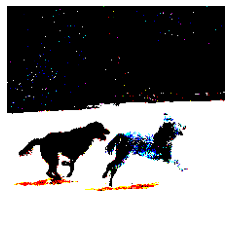

In [0]:
img = preprocess_img("/content/flickr8k_dataset/Flicker8k_Dataset/2513260012_03d33305cf.jpg")

plt.imshow(img[0])
plt.axis("off")
plt.show()

In [0]:
def encode_img(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1 , ))
  return feature_vector

In [0]:
encoding_train = {}

# map img_id-->feature_vector

for ix , img_id in enumerate(train):
  img_path = IMG_PATH + img_id + ".jpg"
  encoding_train[img_id] = encode_img(img_path)




In [0]:
# above process took lots of time so we will save this file and use this for future training purposes

with open("encoding_train_features.pkl" , "wb") as f:
  pickle.dump(encoding_train , f)

In [0]:
encoding_test = {}

# map img_id-->feature_vector

for ix , img_id in enumerate(test):
  img_path = IMG_PATH + img_id + ".jpg"
  encoding_test[img_id] = encode_img(img_path)




In [0]:

with open("encoding_test_features.pkl" , "wb") as f:
  pickle.dump(encoding_train , f)

In [0]:
# Data preprocessing for the captions

len(total_words)

2070

In [0]:
word_to_idx = {}
idx_to_word = {}

for i , word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word


In [0]:
word_to_idx["dog"]
idx_to_word[7]

print(len(idx_to_word))

2070


In [0]:
# Two special words startseq and endseq

idx_to_word[2071] = "startseq"
word_to_idx["startseq"] = 2071

idx_to_word[2072] = "endseq"
word_to_idx["endseq"] = 2072

In [0]:
# Our final vocab size

vocab_size = len(idx_to_word) + 1
print("Final Vocab Size = ", vocab_size)

Final Vocab Size =  2073


In [0]:
max_len = 0

for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len , len(cap.split()))


print(max_len)

35


In [0]:
def data_generator(train_descriptions , encoding_train , word_to_idx, max_len , batch_size):

  x1 , x2 , y = [] , [] , []

  n=0
  while True:
    for key , des_list in train_descriptions.items():
      n+=1

      photo = encoding_train[key]
      for des in des_list:
        seq = [word_to_idx[word] for word in des.split() if word in word_to_idx]

        for i in range(1 , len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          # 0 is the padding number
          xi = pad_sequences([xi] , maxlen = max_len , value = 0 , padding = "post")[0]
          # Y = one_hot vector
          yi = to_categorical([yi] , num_classes = vocab_size)[0]

          x1.append(photo)
          x2.append(xi)
          y.append(yi)

        if(n == batch_size):

          # when control comes back to this function it needs to remember till what values it had processed
          # And reset the previous values for the next batch of photographs
          yield[[np.array(x1) , np.array(x2)] , np.array(y)]
          n=0
          x1 , x2 , y = [] ,[] ,[]





In [0]:
# Word embeddings

f = open("/content/glove.6B.50d.txt" , encoding = 'utf-8')


In [0]:
embedding_index = {}

for line in f:
  values = line.split()
  # 1st word is word and next 50 are its vector values

  word = values[0]
  word_embedding = np.array(values[1:] , dtype = 'float')
  embedding_index[word] = word_embedding


f.close()

In [0]:
# Now we have made a copy of the 6billion words
# Now we need to extract the words we want to use

In [0]:
def get_embedding_matrix():
  emb_dims= 50
  matrix = np.zeros((vocab_size , emb_dims))

  for word , idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if(embedding_vector is not None):
      matrix[idx] = embedding_vector

  return matrix

In [0]:
embedding_matrix = get_embedding_matrix()

embedding_matrix.shape

(2073, 50)

In [0]:
## Model Architecture

input_image_features = Input(shape = (2048 ,))
inp_img1 = Dropout(0.3)(input_image_features)
inp_img2 = Dense(256 , activation='relu')(inp_img1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
## Captions as input 

input_captions = Input(shape=(max_len , ))
inp_cap1 = Embedding(input_dim=vocab_size , output_dim = 50 , mask_zero =True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256 ,activation='relu')(decoder1)

outputs = Dense(vocab_size , activation = 'softmax')(decoder2)

## Combined model
model = Model(inputs = [input_image_features , input_captions] , outputs = outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       103650      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
# Link the embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss = 'categorical_crossentropy' , optimizer='adam')

In [0]:
## training of model

epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size
# number of pics per batch

# steps_per_epochs = how many times we want to call our generator
# steps_per_epochs = total_image_train / (batch_size)



In [0]:
def train():

  for i in range(epochs):
    # this is a generator instance
    generator = data_generator(train_descriptions , encoding_train, word_to_idx , max_len , batch_size)
    model.fit_generator(generator, epochs=1 , steps_per_epoch = steps , verbose=1)

    model.save("/content/model_weights/"+str(i)+'.h5')


In [80]:
train()

Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 3.6670
Epoch 1/1
2000/2000 [==============================] - 165s 82ms/step - loss: 3.3751
Epoch 1/1
2000/2000 [==============================] - 165s 83ms/step - loss: 3.1874
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 3.0574
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.9508
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.8638
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.7968
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.7402
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.6832
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.6392
Epoch 1/1
2000/2000 [==============================] - 163s 82ms/step - loss: 2.6023
Epoch 1/1
2000/2000 [==============================] - 164s 82ms/

In [0]:
model = load_model('/content/model_weights/19.h5')

In [0]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

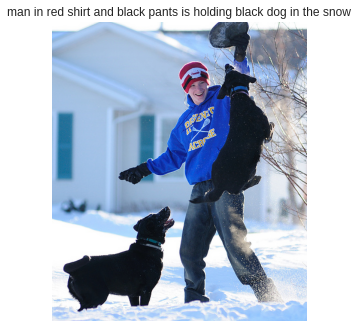

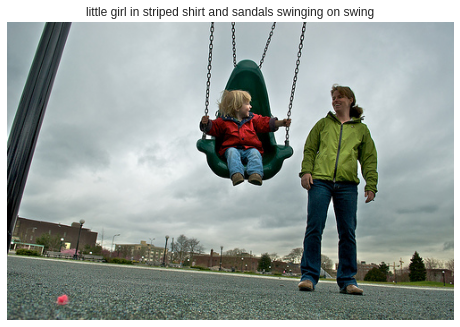

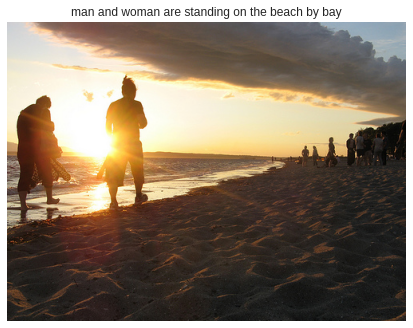

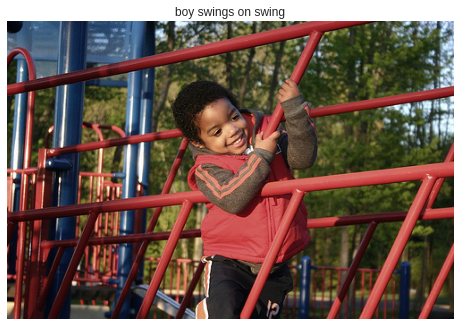

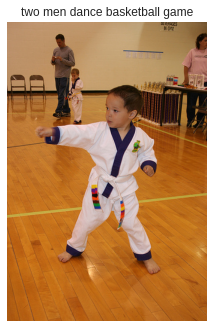

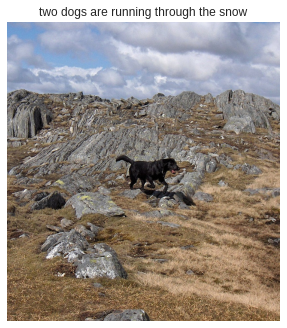

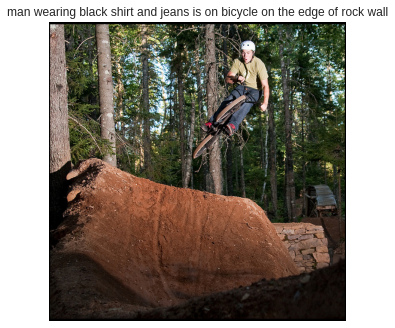

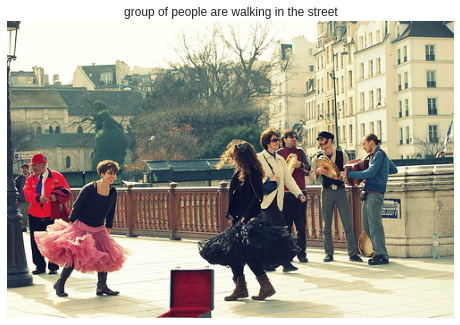

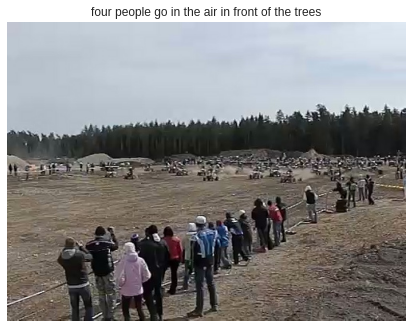

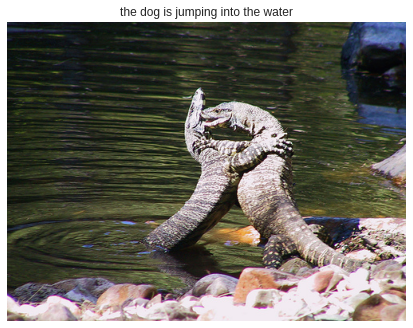

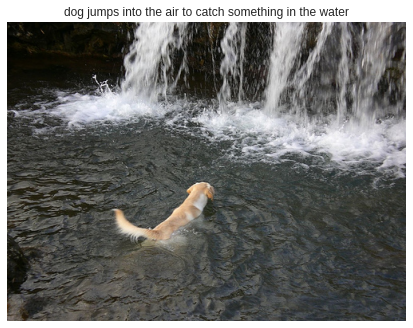

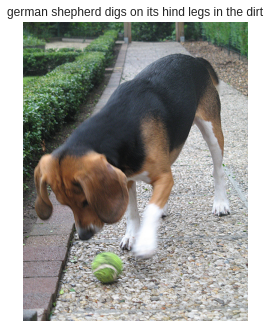

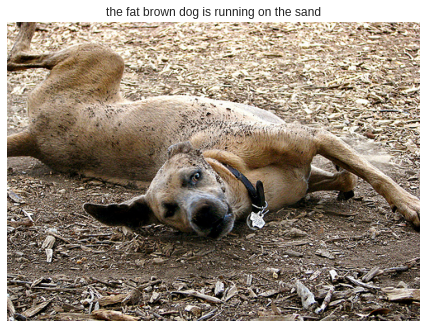

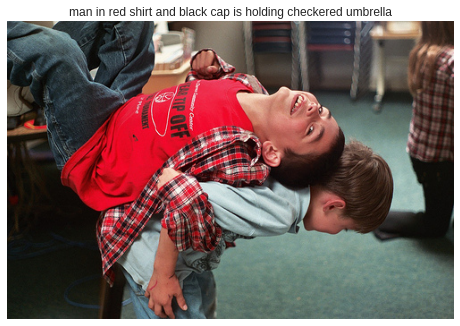

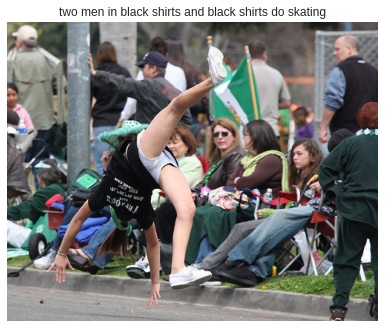

In [84]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    